In [4]:
import cv2
import torch

model_type = 'ZoeD_N'
model_zoe_nk = torch.hub.load("./ZoeDepth", model_type,  source="local", pretrained=True)

"""Move model to GPU if available"""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_zoe_nk = model_zoe_nk.to(device)
device


img_size [384, 512]


Using cache found in /home/feng/.cache/torch/hub/intel-isl_MiDaS_master
/home/feng/anaconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


device(type='cuda')

In [5]:
from PIL import Image

images_path = [
    "/home/feng/Downloads/photo_2023-11-12_11-35-58.jpg",
    "/home/feng/Downloads/Telegram Desktop/photo_2023-11-12_11-44-31.jpg",
    "/home/feng/Downloads/Telegram Desktop/photo_2023-11-12_10-26-43.jpg",
    "/home/feng/Downloads/Telegram Desktop/photo_2023-11-12_10-26-40.jpg",
    "/home/feng/Downloads/Telegram Desktop/photo_2023-11-12_10-26-37.jpg"
]

frames = [ cv2.imread(path) for path in images_path]


In [6]:
from intelisl_midas_v2 import *
import matplotlib.pyplot as plt


def process_frrame(frame):
    labels, num_pix = get_image_super_pixels(frame)

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    img = Image.fromarray(rgb_frame)

    output = model_zoe_nk.infer_pil(img)


    h, w = output.shape

    n_segments = 3

    # print(np.array([seg.mean() for seg in segments]).reshape(4, 4))
    # Rescale the depth map for visualization
    depth_colormap = cv2.normalize(output, None, 0, 1, cv2.NORM_MINMAX)

    depth_colormap = 1 - depth_colormap

    depth_colormap = (depth_colormap * 255).astype(np.uint8)
    depth_colormap = cv2.applyColorMap(depth_colormap, cv2.COLORMAP_MAGMA)

    depth_w_superpixel_norm = apply_superpixel_mean(
        depth_colormap, labels, num_pix
    )

    depth_w_superpixel_norm = cv2.cvtColor(depth_w_superpixel_norm, cv2.COLOR_BGR2RGB)

    return depth_w_superpixel_norm, (output, labels, num_pix)


processed_frames = []
params = []

for frame in frames:
    proc, args = process_frrame(frame)
    processed_frames.append(proc)
    params.append(args)
    

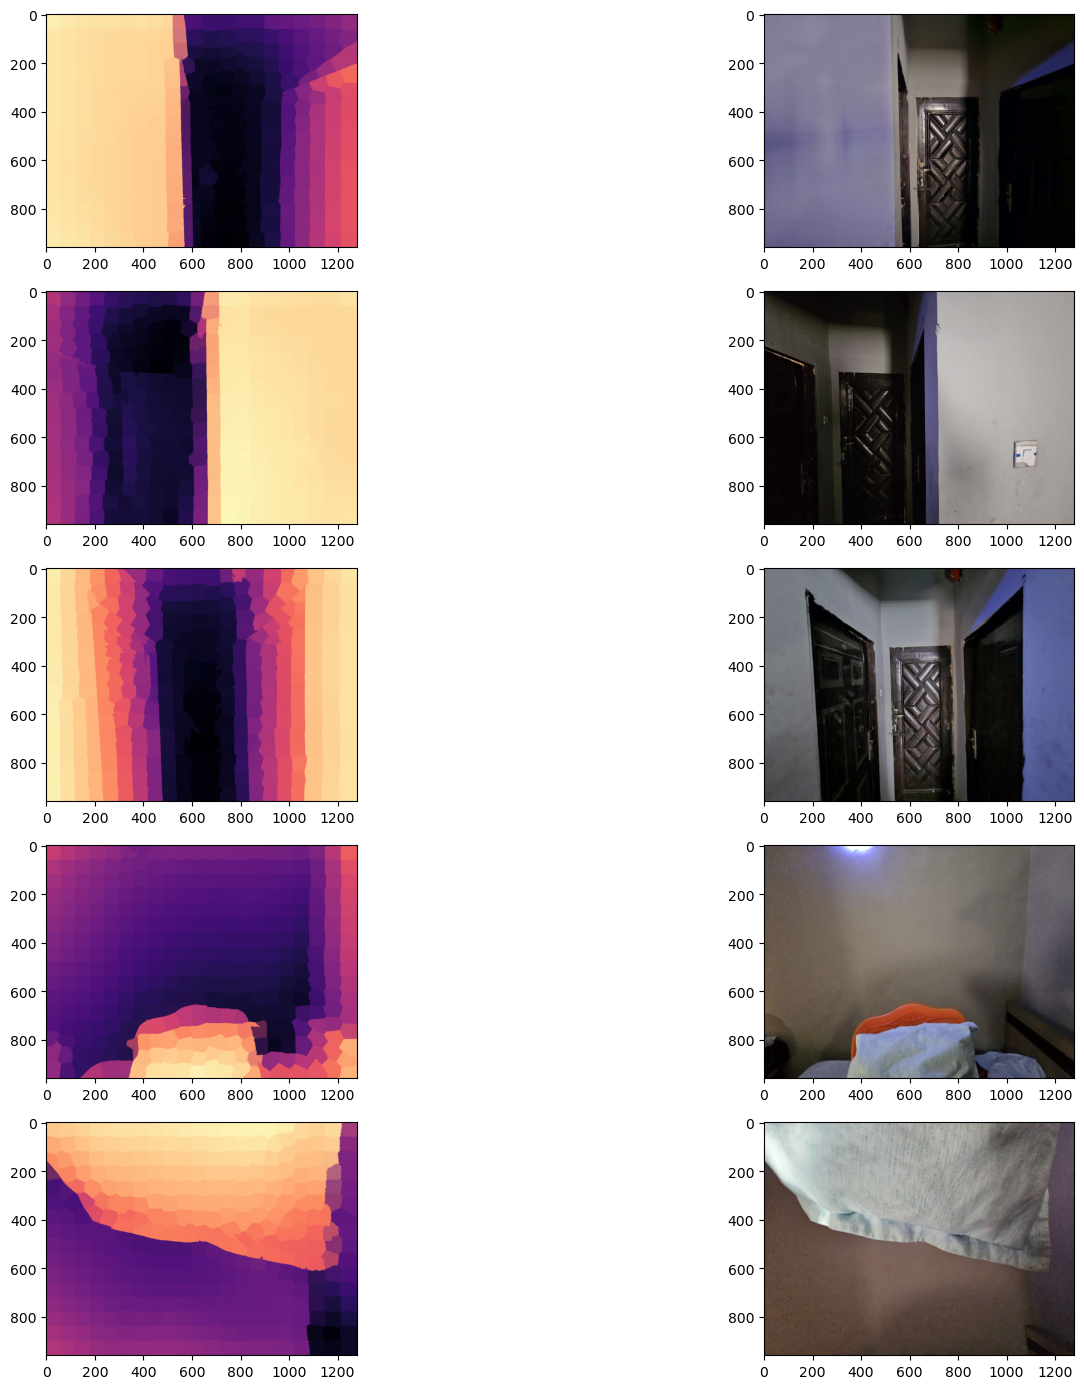

In [7]:
n = len(frames)
fig, axis = plt.subplots(n, 2, figsize=(18, 14))


for i, imgs in enumerate(zip(processed_frames, frames)):
    ax_1, ax_2 = axis[i]
    ax_1.imshow(imgs[0])
    ax_2.imshow(cv2.cvtColor(imgs[1], cv2.COLOR_BGR2RGB))
    
plt.tight_layout()
plt.show()


In [8]:
def generate_stereo_audio(freq, amplitude, azimuth_angle, sample_rate, duration=3):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

    sound_wave = np.sin(2 * np.pi * freq * t)

    # Function to apply panning based on angle
    def apply_panning(sound_wave, angle):
        # Calculate left and right channel volume based on the angle
        left_volume = np.cos(np.deg2rad(angle)) * amplitude
        right_volume = np.sin(np.deg2rad(angle)) * amplitude

        # Create stereo audio
        stereo_audio = np.column_stack(
            (sound_wave * left_volume, sound_wave * right_volume)
        )

        return stereo_audio

    # Apply panning based on the angle
    panned_audio = apply_panning(sound_wave, azimuth_angle)

    return panned_audio

def sonify_image(labels_mean_depth, labels, num_labels):
    horizontal_segment_count = len(np.unique(labels[0]))
    vertical_segment_count = len(np.unique(labels[:, 0]))
    pix_count = get_pixel_count_per_label(labels, num_labels)

    azimuth_angles = np.linspace(0, 90, horizontal_segment_count - 1)

    horizontal_slice = get_horizontal_slices(labels, horizontal_segment_count)
    vertical_slices = get_vertical_slices(labels, vertical_segment_count)

    params = np.zeros(
        (
            num_labels,
            3,
        )
    )

    for idx, _slice in enumerate(horizontal_slice):
        label_propotion = {k: v / pix_count.get(k) for k, v in Counter(_slice).items()}
        for label in label_propotion:
            if label_propotion[label] >= 0.5:
                params[label, 0] = azimuth_angles[idx]

    for idx, _slice in enumerate(vertical_slices):
        label_propotion = {k: v / pix_count.get(k) for k, v in Counter(_slice).items()}
        for label in label_propotion:
            if label_propotion[label] >= 0.5:
                params[label, 1] = SEMI_TONE * (
                    2 ** ((idx - 6) / 12)
                )  # set to -6 to +6 st

    loud = 0
    for label in range(num_labels):
        depth = labels_mean_depth[label]
        if depth > 1.5:
            amp = 0
        else:
            amp = 1 / (depth + 1)
            loud += 1

        params[label, 2] = amp

    samples = [
        generate_stereo_audio(params[i, 1], params[i, 2], params[i, 0], SAMPLE_RATE, 1)
        for i in range(num_labels)
    ]


    audio = np.sum(samples, axis=0, dtype=np.float32)

    audio = (audio / (np.max(audio) + 1))

    return audio


In [27]:
output, labels, num_pix = params[0]

label_values =   get_superpixel_mean(output, labels, num_pix)
# print(label_values)
audio = sonify_image(label_values, labels, num_pix )

# max_amplitude = np.max(np.abs(audio))
# if max_amplitude >= 1:
#     audio /= max_amplitude


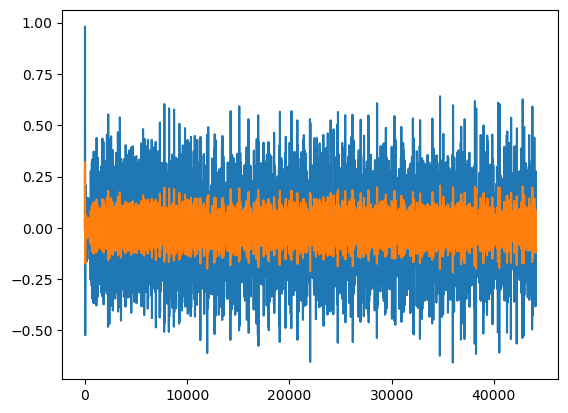

In [28]:
plt.plot(audio)

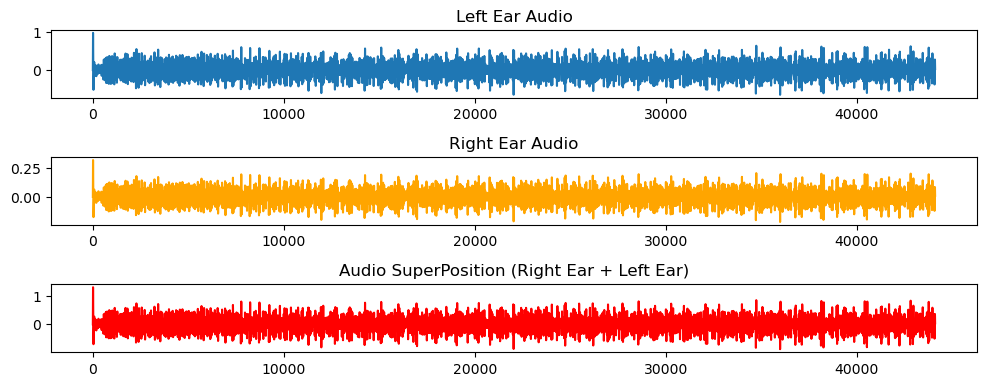

In [29]:
ax = plt.figure(figsize=(10, 5))

plt.subplot(4, 1, 1)
plt.plot(audio[:, 0])
plt.title('Left Ear Audio')

plt.subplot(4, 1, 2)
plt.plot(audio[:, 1], color='orange')
plt.title('Right Ear Audio')

plt.subplot(4, 1, 3)
plt.plot(audio[:, 1] + audio[:, 0], color='red')
plt.title('Audio SuperPosition (Right Ear + Left Ear)')
plt.tight_layout()
plt.show()


In [30]:
import soundfile as sf
from pydub import AudioSegment
from pydub.playback import play

# Constants


sf.write("tmp.wav", audio, SAMPLE_RATE)

# Load the WAV file using pydub
audio_segment = AudioSegment.from_wav("tmp.wav")

# Play the audio
play(audio_segment)


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


In [77]:
import math



<function math.acos(x, /)>